In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import os

In [5]:
import torchvision.transforms as transforms
trans=transforms.Compose([
    transforms.RandomAdjustSharpness(1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=3, sigma=0.1)
])

In [20]:
print(os.listdir("/content/drive/MyDrive/DL_project/TRAIN"))

['TRAIN_3', 'TRAIN_2', 'TRAIN_1', 'TRAIN_4', 'TRAIN_0']


In [6]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TRAIN")
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data):
    full_path="/content/drive/MyDrive/DL_project/TRAIN/"+path+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)
train_lst,val_lst,train_labels,val_labels=train_test_split(all_paths,all_labels,test_size=0.2)

In [7]:
class DataSet(Dataset):
    def __init__(self,paths,labels,transform=None):
        self.transform=transform
        self.images_path=paths
        self.labels=labels
        if(transform is not None):
            self.images_path=np.append(self.images_path,self.images_path)
            self.labels=np.append(self.labels,self.labels)
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self,idx):
        hf=len(self.images_path)/2
        img=self.images_path[idx]
        image=cv2.imread(img)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image,(299,299), interpolation=cv2.INTER_CUBIC)
        resized_image=np.array(resized_image)
        resized_image=torch.tensor(resized_image)
        if(self.transform is not None):
            half=len(self.images_path)/2
            if(idx>=half):
                resized_image=torch.reshape(resized_image,(3,299,299))
                resized_image=self.transform(resized_image)
                return self.transform(resized_image),self.labels[idx]
        resized_image=torch.reshape(resized_image,(3,299,299))
        return resized_image,self.labels[idx]

In [8]:
train_dataset=DataSet(train_lst,train_labels,trans)
val_dataset=DataSet(val_lst,val_labels,trans)
train_dataloader=DataLoader(train_dataset,batch_size=12,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=12,shuffle=True)

In [9]:
import torchvision
from torchvision.models import inception_v3
import warnings
warnings.filterwarnings("ignore")
class Inception(nn.Module):
    def __init__(self):
        super().__init__()
        self.res=inception_v3(pretrained=True).to(device)
        self.res.aux_logits = False
        for param in self.res.parameters():
            param.requires_grad=False
        self.classifier=nn.Sequential(
            nn.Linear(1000,150).to(device),
            nn.Dropout(0.5),
            nn.Linear(150,5).to(device)
        )
        
    def forward(self,x):
        x=x.to(torch.float32)
        x=x.to(device)
        x=self.res(x)
        x=self.classifier(x)
        x=torch.nn.functional.softmax(x, dim=1)
        return x

In [10]:
from sklearn.metrics import accuracy_score,precision_score,f1_score
def get_acc(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return accuracy_score(arr,arr2)
def get_prec(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return precision_score(arr,arr2,average='macro')
def get_f1(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return f1_score(arr,arr2,average='macro')

In [11]:
from tqdm import tqdm

In [12]:
def train(model,train_dataloader,epochs,optimizer,criterion,val_loader):
    tr_acc_l=[]
    tr_loss_l=[]
    tr_prec_l=[]
    tr_f1_l=[]
    val_acc_l=[]
    val_prec_l=[]
    val_f1_l=[]
    val_loss_l=[]
    for ep in range(epochs):  
        model.train()
        running_loss = 0.0
        tr_acc=0
        tr_prec=0
        tr_f1=0
        for i,data in tqdm(enumerate(train_dataloader)):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs=outputs.to('cpu')
            labels=labels.to(torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            outputs=torch.argmax(outputs,dim=1)
            tr_acc+=get_acc(outputs,labels)
            tr_prec+=get_prec(outputs,labels)
            tr_f1+=get_f1(outputs,labels)
            if(i%25==0):
                sen = f"Training Epochs:{ep} Mini Batch {i+1},Running Loss {running_loss/(i+1)} ,Accuracy:{tr_acc/(i+1)},Precision:{tr_prec/(i+1)},F1:{tr_f1/(i+1)}"
                print(sen)
        running_loss/=(i+1)
        tr_acc=tr_acc/(i+1)
        tr_prec=tr_prec/(i+1)
        tr_f1=tr_f1/(i+1)
        sen = f"Training Epochs:{ep},Running Loss {running_loss} ,Accuracy:{tr_acc},Precision:{tr_prec},F1:{tr_f1}"
        print(sen)
        tr_acc_l.append(tr_acc)
        tr_prec_l.append(tr_prec)
        tr_f1_l.append(tr_f1)
        tr_loss_l.append(running_loss)
        model.eval()
        with torch.no_grad():
            total_loss = 0
            val_acc=0
            val_prec=0
            val_f1=0
            for i,(inputs, targets) in tqdm(enumerate(val_loader)):
                outputs = model(inputs)
                targets=targets.to(torch.long)
                targets=targets.to('cpu')
                outputs=outputs.to('cpu')
                loss = criterion(outputs, targets)
                total_loss += loss.item()
                outputs=torch.argmax(outputs,dim=1)
                val_acc+=get_acc(outputs,targets)
                val_prec+=get_prec(outputs,targets)
                val_f1+=get_f1(outputs,targets)
                if(i%25==0):
                    sen = f"Validation Epochs:{ep} Mini Batch {i+1},Running Loss {total_loss/(i+1)} ,Accuracy:{val_acc/(i+1)},Precision:{val_prec/(i+1)},F1:{val_f1/(i+1)}"
                    print(sen)
            val_acc/=(i+1)
            total_loss/=(i+1)
            val_prec/=(i+1)
            val_f1/=(i+1)
            sen = f"Validation Epochs:{ep},Running Loss {total_loss} ,Accuracy:{val_acc},Precision:{val_prec},F1:{val_f1}"
            print(sen)
            val_acc_l.append(val_acc)
            val_prec_l.append(val_prec)
            val_f1_l.append(val_f1)
            val_loss_l.append(total_loss)
    return tr_acc_l,tr_prec_l,tr_f1_l,tr_loss_l,val_acc_l,val_prec_l,val_f1_l,val_loss_l       

In [13]:
import torch.optim as optim
model=Inception()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 375MB/s] 


In [14]:
lst=train(model,train_dataloader,4,optimizer,criterion,val_dataloader)

1it [00:26, 26.86s/it]

Training Epochs:0 Mini Batch 1,Running Loss 1.626612663269043 ,Accuracy:0.16666666666666666,Precision:0.13333333333333333,F1:0.16


26it [05:12,  9.92s/it]

Training Epochs:0 Mini Batch 26,Running Loss 1.5259351134300232 ,Accuracy:0.3397435897435898,Precision:0.29382326007326015,F1:0.27643883893883897


51it [08:51,  7.87s/it]

Training Epochs:0 Mini Batch 51,Running Loss 1.5185640910092522 ,Accuracy:0.3464052287581701,Precision:0.29542717086834736,F1:0.27635712871006984


76it [11:29,  4.18s/it]

Training Epochs:0 Mini Batch 76,Running Loss 1.5128218610035746 ,Accuracy:0.35526315789473684,Precision:0.29535244360902263,F1:0.273122863978127


101it [13:07,  2.40s/it]

Training Epochs:0 Mini Batch 101,Running Loss 1.5088447379593801 ,Accuracy:0.3646864686468647,Precision:0.3085608203677511,F1:0.27729012736438474


111it [13:24,  7.25s/it]


Training Epochs:0,Running Loss 1.5086470928278055 ,Accuracy:0.36636636636636655,Precision:0.3162205062205064,F1:0.28317373067373064


1it [00:12, 12.03s/it]

Validation Epochs:0 Mini Batch 1,Running Loss 1.2992920875549316 ,Accuracy:0.5833333333333334,Precision:0.3333333333333333,F1:0.35


26it [03:12,  3.09s/it]

Validation Epochs:0 Mini Batch 26,Running Loss 1.4324755714489863 ,Accuracy:0.4455128205128206,Precision:0.369720695970696,F1:0.34193482799252034


28it [03:15,  6.97s/it]


Validation Epochs:0,Running Loss 1.4315518268517085 ,Accuracy:0.4449404761904763,Precision:0.362062074829932,F1:0.33379492531278254


1it [00:01,  1.23s/it]

Training Epochs:1 Mini Batch 1,Running Loss 1.370086669921875 ,Accuracy:0.5,Precision:0.29333333333333333,F1:0.33777777777777784


26it [00:33,  1.47s/it]

Training Epochs:1 Mini Batch 26,Running Loss 1.4686606113727276 ,Accuracy:0.40705128205128216,Precision:0.3408310439560439,F1:0.325595238095238


51it [01:07,  1.45s/it]

Training Epochs:1 Mini Batch 51,Running Loss 1.4554122920129813 ,Accuracy:0.4264705882352941,Precision:0.3758169934640523,F1:0.3529739759151523


76it [01:42,  1.32s/it]

Training Epochs:1 Mini Batch 76,Running Loss 1.4671233390506946 ,Accuracy:0.4111842105263159,Precision:0.3648355263157895,F1:0.33792794924373865


101it [02:15,  1.37s/it]

Training Epochs:1 Mini Batch 101,Running Loss 1.4649860221560638 ,Accuracy:0.41996699669967,Precision:0.3728630363036303,F1:0.3410748822134959


111it [02:28,  1.33s/it]


Training Epochs:1,Running Loss 1.4717943152865849 ,Accuracy:0.4121621621621622,Precision:0.36580223080223073,F1:0.3334093409093408


1it [00:01,  1.45s/it]

Validation Epochs:1 Mini Batch 1,Running Loss 1.579614520072937 ,Accuracy:0.25,Precision:0.18333333333333332,F1:0.16


26it [00:32,  1.07s/it]

Validation Epochs:1 Mini Batch 26,Running Loss 1.4309734793809743 ,Accuracy:0.47435897435897434,Precision:0.4005173992673993,F1:0.3654828825021132


28it [00:34,  1.24s/it]


Validation Epochs:1,Running Loss 1.4328894232000624 ,Accuracy:0.4717261904761904,Precision:0.40286139455782316,F1:0.36760825484039766


1it [00:01,  1.23s/it]

Training Epochs:2 Mini Batch 1,Running Loss 1.3721085786819458 ,Accuracy:0.5,Precision:0.5,F1:0.34444444444444444


26it [00:35,  1.39s/it]

Training Epochs:2 Mini Batch 26,Running Loss 1.4160448358609126 ,Accuracy:0.47435897435897445,Precision:0.41361111111111115,F1:0.3716115828615828


51it [01:08,  1.16s/it]

Training Epochs:2 Mini Batch 51,Running Loss 1.4292216113969392 ,Accuracy:0.46568627450980404,Precision:0.4092405851229381,F1:0.36399753840930316


76it [01:42,  1.29s/it]

Training Epochs:2 Mini Batch 76,Running Loss 1.4328932683718831 ,Accuracy:0.4594298245614036,Precision:0.40632518796992484,F1:0.3602773031062505


101it [02:15,  1.37s/it]

Training Epochs:2 Mini Batch 101,Running Loss 1.4371576981969398 ,Accuracy:0.4521452145214523,Precision:0.3965069542668553,F1:0.35241744504120737


111it [02:27,  1.33s/it]


Training Epochs:2,Running Loss 1.4332335757779646 ,Accuracy:0.45570570570570584,Precision:0.39806038181038195,F1:0.35479432979432973


1it [00:01,  1.06s/it]

Validation Epochs:2 Mini Batch 1,Running Loss 1.4968925714492798 ,Accuracy:0.3333333333333333,Precision:0.21666666666666665,F1:0.2133333333333333


26it [00:32,  1.17s/it]

Validation Epochs:2 Mini Batch 26,Running Loss 1.4048939530666058 ,Accuracy:0.48076923076923084,Precision:0.37191163003662997,F1:0.3375345236714015


28it [00:34,  1.24s/it]


Validation Epochs:2,Running Loss 1.4106807027544295 ,Accuracy:0.474702380952381,Precision:0.3724298469387755,F1:0.33425824817106337


1it [00:01,  1.59s/it]

Training Epochs:3 Mini Batch 1,Running Loss 1.603742241859436 ,Accuracy:0.25,Precision:0.35,F1:0.2038095238095238


26it [00:34,  1.27s/it]

Training Epochs:3 Mini Batch 26,Running Loss 1.4820425693805401 ,Accuracy:0.4006410256410256,Precision:0.3438736263736264,F1:0.2880769230769231


51it [01:08,  1.40s/it]

Training Epochs:3 Mini Batch 51,Running Loss 1.463181778496387 ,Accuracy:0.41503267973856217,Precision:0.367889822595705,F1:0.3148373086608382


76it [01:42,  1.38s/it]

Training Epochs:3 Mini Batch 76,Running Loss 1.4583980786172968 ,Accuracy:0.41995614035087714,Precision:0.3689708646616543,F1:0.3199929273942433


101it [02:15,  1.37s/it]

Training Epochs:3 Mini Batch 101,Running Loss 1.446590777670983 ,Accuracy:0.4364686468646865,Precision:0.38766148043375775,F1:0.33815513694226573


111it [02:26,  1.32s/it]


Training Epochs:3,Running Loss 1.4386558726027205 ,Accuracy:0.44594594594594594,Precision:0.3956274131274133,F1:0.34586056836056844


1it [00:01,  1.32s/it]

Validation Epochs:3 Mini Batch 1,Running Loss 1.1883935928344727 ,Accuracy:0.6666666666666666,Precision:0.4666666666666666,F1:0.4


26it [00:32,  1.22s/it]

Validation Epochs:3 Mini Batch 26,Running Loss 1.3916681592281048 ,Accuracy:0.5064102564102563,Precision:0.393422619047619,F1:0.3636455638378715


28it [00:34,  1.24s/it]

Validation Epochs:3,Running Loss 1.3910614252090454 ,Accuracy:0.5089285714285714,Precision:0.40609481292516997,F1:0.37002632288346576


In [19]:
print(os.listdir("/content/drive/MyDrive/DL_project/TEST"))

['TEST_2', 'TEST_0', 'TEST_4', 'TEST_1', 'TEST_3']


110it [02:18,  1.26s/it]


Testing ,Running Loss 1.456328062577681 ,Accuracy:0.4318181818181819,Precision:0.2773181818181818,F1:0.2563253715980987


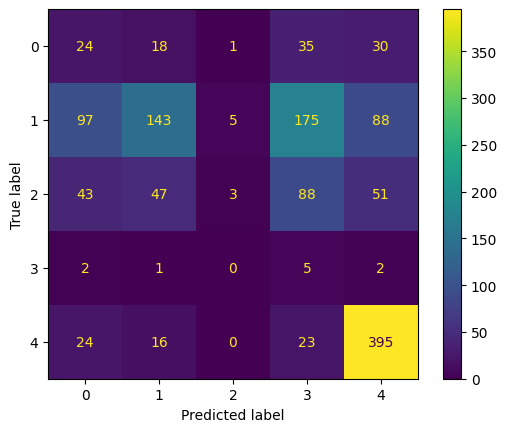

In [23]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TEST")
train_data_2=[0,0,0,0,0]
train_data_2[0]=train_data[-1]
train_data_2[1]=train_data[0]
train_data_2[2]=train_data[3]
train_data_2[3]=train_data[2]
train_data_2[4]=train_data[1]
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data_2):
    full_path="/content/drive/MyDrive/DL_project/TEST/"+path+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)
test_dataset=DataSet(all_paths,all_labels,trans)
test_loader=DataLoader(test_dataset,batch_size=12,shuffle=True)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
with torch.no_grad():
    total_loss = 0
    test_acc=0
    test_prec=0
    test_f1=0
    testing_pred=None
    testing_out=None
    for i,(inputs, targets) in tqdm(enumerate(test_loader)):
        outputs = model(inputs)
        targets=targets.to(torch.long)
        targets=targets.to('cpu')
        outputs=outputs.to('cpu')
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        outputs=torch.argmax(outputs,dim=1)
        test_acc+=get_acc(outputs,targets)
        test_prec+=get_prec(outputs,targets)
        test_f1+=get_f1(outputs,targets)
        if(testing_pred is None):
            testing_pred=np.array(outputs)
            testing_out=np.array(targets)
        else:
            testing_pred=np.concatenate([testing_pred,np.array(outputs)],axis=0)
            testing_out=np.concatenate([testing_out,np.array(targets)],axis=0)        
    test_acc/=(i+1)
    total_loss/=(i+1)
    test_prec/=(i+1)
    test_f1/=(i+1)
    sen = f"Testing ,Running Loss {total_loss} ,Accuracy:{test_acc},Precision:{test_prec},F1:{test_f1}"
    print(sen)
    cm = confusion_matrix(testing_out,testing_pred, labels=[i for i in range(5)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[i for i in range(5)])
    disp.plot()
    plt.show()

In [24]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(testing_out,testing_pred)
print("Kappa score:", kappa)

Kappa score: 0.2632154060909896
